In [22]:
import Pkg
using ClimaAnalysis
using EnsembleKalmanProcesses
using CairoMakie
using Statistics
using JLD2

In [2]:
Pkg.status()

Status `~/Documents/Research/loss/ClimaAtmos.jl/calibration/experiments/explore_loss_functions/Project.toml`
  [0a1fb500] BlockDiagonals v0.1.42
  [13f3f980] CairoMakie v0.12.3
  [29b5916a] ClimaAnalysis v0.5.3
  [b2c96348] ClimaAtmos v0.26.2 `../../..`
  [4347a170] ClimaCalibrate v0.1.0 `https://github.com/CliMA/ClimaCalibrate.jl#main`
  [5c42b081] ClimaParams v0.10.8
  [31c24e10] Distributions v0.25.109
  [aa8a2aa5] EnsembleKalmanProcesses v1.1.5
  [033835bb] JLD2 v0.4.48
⌃ [30363a11] NetCDF v0.11.8
  [295af30f] Revise v3.5.14
  [ddb6d928] YAML v0.4.11
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
  [10745b16] Statistics v1.10.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [140]:
# read in ensemble data
cases =  filter(readdir("output")) do x
    occursin("obs", x) && occursin("001", x) 
end
file_paths = ["output/$x/2param_calibration.jld2" for x in cases]
true_params = [0.3, 0.14]

2-element Vector{Float64}:
 0.3
 0.14

In [141]:
vars = map(sim_id -> split(sim_id, "_")[2], cases)
learning_rate = map(sim_id -> split(sim_id, "_")[3], cases)
println(vars)
println(learning_rate)

SubString{String}["cl", "clw", "hus", "ta", "ta", "ua", "va", "wa"]
SubString{String}["0.001", "0.001", "0.001", "0.0001", "0.001", "0.001", "0.001", "0.001"]


In [142]:

dat = mean(JLD2.load(file_paths[1])["ar"][2], dims = 1)

1×4 Matrix{Float64}:
 0.208863  0.172415  0.18789  0.172475

In [143]:
dat

1×4 Matrix{Float64}:
 0.208863  0.172415  0.18789  0.172475

In [144]:
function bias_and_mse(file_path, true_params, index)
    data = JLD2.load(file_path)["ar"][index] .- true_params[index]
    bias = mean(data, dims = 1)
    mse = sqrt.(mean(data.^2, dims = 1))
    return bias, mse
end

bias_mse = map(file_path -> bias_and_mse(file_path, true_params, 1), file_paths)
println(bias_mse)

[([0.13130776256800725 -0.03157091115620088 -0.028863726642843972 0.010620436780149622], [0.17147817060914844 0.044261912475737235 0.034152178613007345 0.011227685342953988]), ([0.13130776256800725 0.052353149817852385 0.24602084500064686 0.30094193722797724], [0.17147817060914844 0.07797157978968354 0.246800824205123 0.30119270447969365]), ([0.13130776256800725 0.0037711442879542595 -0.008834342841102889 0.0013661499314086873], [0.17147817060914844 0.022125207194543334 0.019603945046338434 0.014724531829875626]), ([0.13130776256800725 -0.08210243150658106 -0.09906849481697708 -0.10803026528508076], [0.17147817060914844 0.0872547832569284 0.0995865939918287 0.10811646668939649]), ([0.13130776256800725 -0.018266063053277454 -0.04671100780665012 -0.06586009328179447], [0.17147817060914844 0.05328805867461224 0.050824892552913926 0.06727889255759309]), ([0.13130776256800725 0.030676964514375665 0.013365487755400831 0.0055917040224821735], [0.17147817060914844 0.0363118981246992 0.01625315

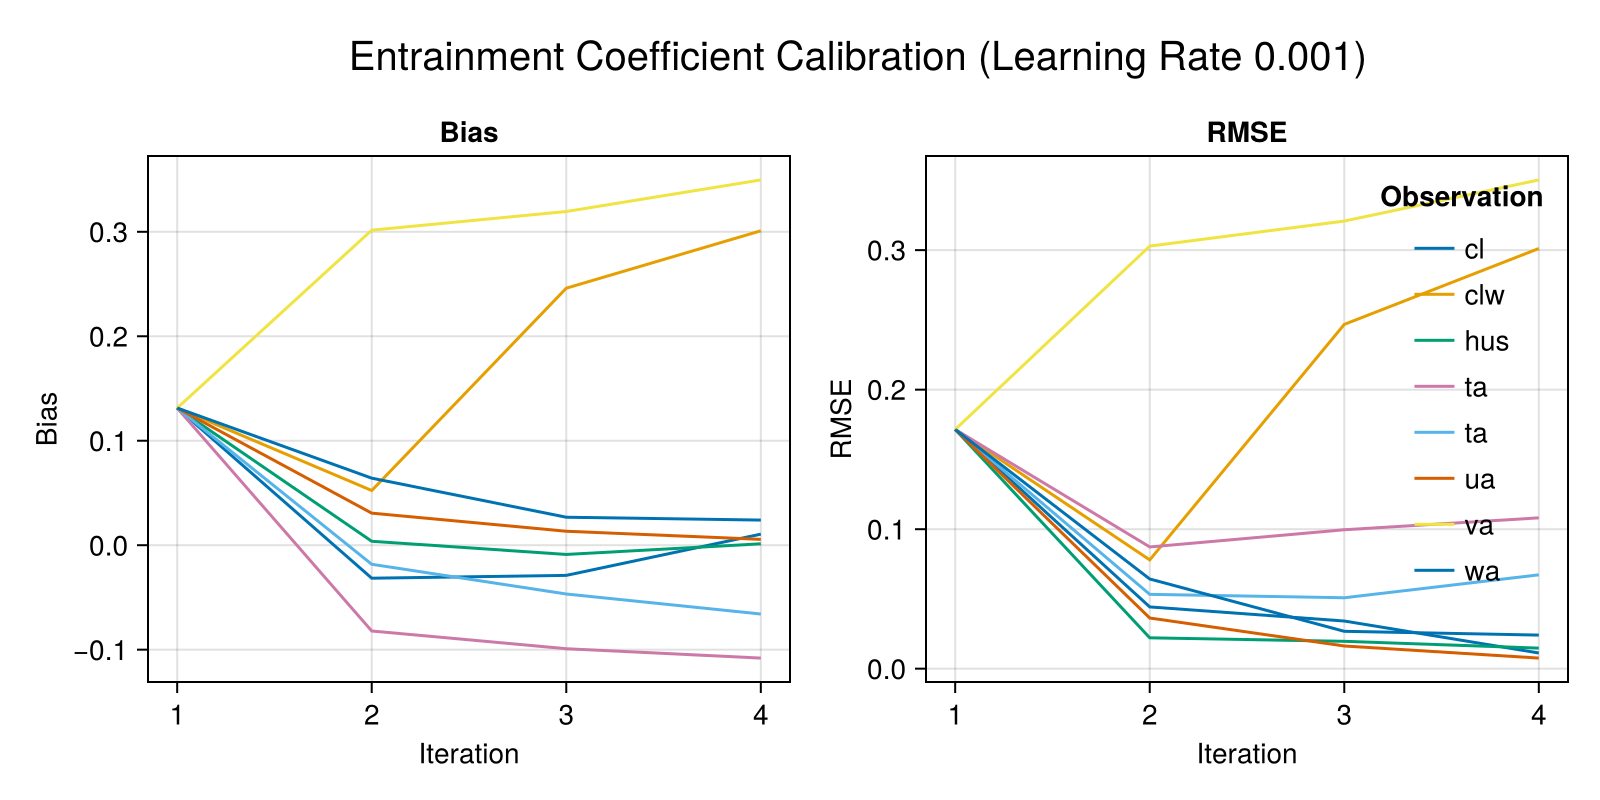

In [151]:
# plot the bias and mse in subplots 
fig = Figure(size = (800, 400))
ax1 = Axis(fig[1, 1], title = "Bias", xlabel = "Iteration", ylabel = "Bias")
ax2 = Axis(fig[1, 2], title = "RMSE", xlabel = "Iteration", ylabel = "RMSE")

for i in 1:length(file_paths)
    bias, mse = bias_mse[i]
    lines!(ax1, vec(bias), colormap= :tab20)
    lines!(ax2, vec(mse), label = "$(vars[i])", colormap=:tab20)
end
# add legend to the plot
axislegend(ax2, "Observation", framevisible = false, position = :rt)

Label(fig[0,:], "Entrainment Coefficient Calibration (Learning Rate $(learning_rate[1]))", fontsize = 20)

CairoMakie.save("plots/entrainment_rate_calibration_$(learning_rate[1]).png", fig)
fig

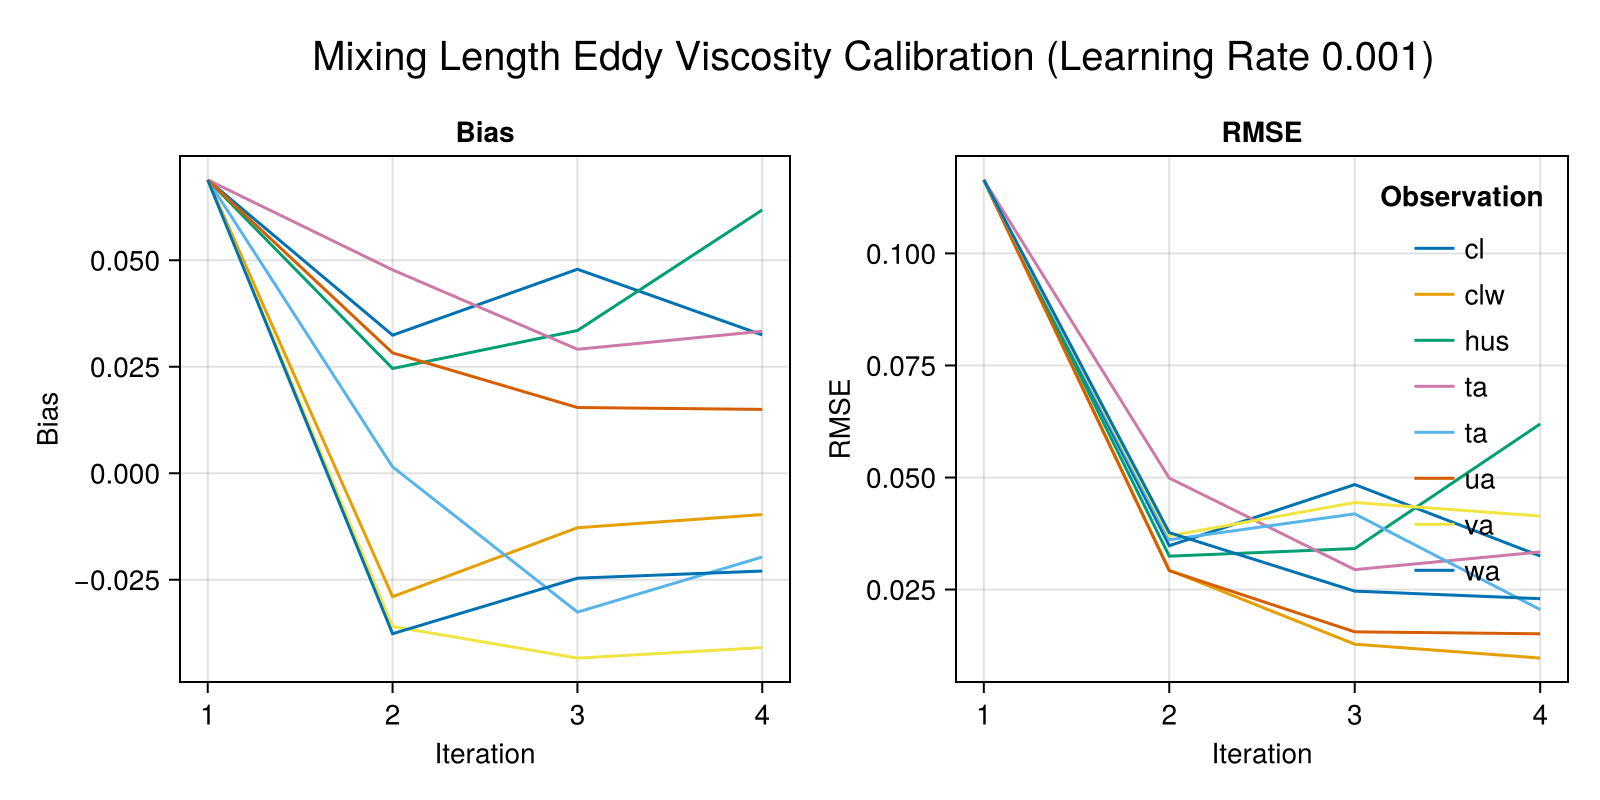

In [150]:
# plot the bias and mse in subplots 
bias_mse2 = map(file_path -> bias_and_mse(file_path, true_params, 2), file_paths)

fig = Figure(size = (800, 400))
ax1 = Axis(fig[1, 1], title = "Bias", xlabel = "Iteration", ylabel = "Bias")
ax2 = Axis(fig[1, 2], title = "RMSE", xlabel = "Iteration", ylabel = "RMSE")

for i in 1:length(file_paths)
    bias, mse = bias_mse2[i]
    lines!(ax1, vec(bias), colormap= :tab20)
    lines!(ax2, vec(mse), label = "$(vars[i])", colormap=:tab20)
end
# add legend to the plot
axislegend(ax2, "Observation", framevisible = false, position = :rt)

Label(fig[0,:], "Mixing Length Eddy Viscosity Calibration (Learning Rate $(learning_rate[1]))", fontsize = 20)
CairoMakie.save("plots/eddy_viscosity_calibration_$(learning_rate[1]).png", fig)
fig

In [132]:
# evaluate ta calibrations across noise functions, since normalized we expect to be the same
# read in files as before and filter for ta in string as well
cases =  filter(readdir("output")) do x
    occursin("ta", x)
end
# repeat getting data for each 
file_paths = ["output/$x/2param_calibration.jld2" for x in cases]
true_params = [0.3, 0.14]
bias_mse_ta = map(file_path -> bias_and_mse(file_path, true_params, 1), file_paths)


5-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([0.13130776256800725 -0.08210243150658106 -0.09906849481697708 -0.10803026528508076], [0.17147817060914844 0.0872547832569284 0.0995865939918287 0.10811646668939649])
 ([0.13130776256800725 -0.018266063053277454 -0.04671100780665012 -0.06586009328179447], [0.17147817060914844 0.05328805867461224 0.050824892552913926 0.06727889255759309])
 ([0.13130776256800725 0.017556865778821023 -0.031619492086449326 -0.053400457287686186], [0.17147817060914844 0.06784051453987826 0.054870728048566596 0.06006282258517407])
 ([0.13130776256800725 0.08437279090627811 0.025102020783006457 0.013166027144563235], [0.17147817060914844 0.12969523164964322 0.07271241131926905 0.06138756365034909])
 ([0.13130776256800725 0.10653454671316141 0.06652900886464358 0.05748920503943507], [0.17147817060914844 0.15083471423809397 0.10842362105098122 0.09844528471470713])

In [137]:
fig = Figure(size = (800, 400))
ax1 = Axis(fig[1, 1], title = "Bias", xlabel = "Iteration", ylabel = "Bias")
ax2 = Axis(fig[1, 2], title = "RMSE", xlabel = "Iteration", ylabel = "RMSE")

for i in 1:length(file_paths)
    bias, mse = bias_mse_ta[i]
    lines!(ax1, vec(bias))
    lines!(ax2, vec(mse), label = "$(split(cases[i], "_")[3])")
end
# add legend to the plot
axislegend(ax2, "Learning Rate", framevisible = false, position = :rt)

Label(fig[0,:], "Learning Rate Effect (observing temperature)", fontsize = 20)
fig
CairoMakie.save("plots/learning_rate_effect.png", fig)

CairoMakie.Screen{IMAGE}
